In [1]:
import numpy as np
import matplotlib.pyplot as plt
import viz_tools

plt.rcParams.update({
    "text.usetex": True,          # Use LaTeX for all text
    "font.family": "serif",       # Use serif font (LaTeX default)
    "font.size": 20,              # Font size
})

In [2]:
# ==========================
# Parametri numerici
# ==========================
N = 2048          # numero di punti spaziali (meglio potenza di 2)
T_final = 1.9999   # tempo finale "nominale"
dt = 0.05e-3          # passo di tempo
DEALIAS = False    # attiva/disattiva dealiasing 2/3

In [3]:

# ==========================
# Griglia spaziale
# ==========================
L = 2.0 * np.pi
x = np.linspace(0.0, L, N, endpoint=False)

# modi interi per FFT: [0,1,...,N/2-1,-N/2,...,-1]
k = np.fft.fftfreq(N) * N
sign_k = np.sign(k)

# maschera 2/3 per dealiasing
if DEALIAS:
    k_cut = N / 3.0
    dealias_mask = np.abs(k) <= k_cut
else:
    dealias_mask = np.ones_like(k, dtype=bool)


# ==========================
# Trasformata di Hilbert periodica
# ==========================
def hilbert(omega):
    """
    Hilbert transform on the periodic domain using FFT.
    """
    omega_hat = np.fft.fft(omega)
    H_hat = -1j * sign_k * omega_hat
    Homega = np.fft.ifft(H_hat)
    return np.real(Homega)


# ==========================
# Right-hand side F(omega) = H(omega) * omega
# ==========================
def rhs(omega):
    Homega = hilbert(omega)
    nonlin = Homega * omega  # prodotto punto-punto

    # dealiasing (2/3 rule) sul termine nonlineare
    if DEALIAS:
        nonlin_hat = np.fft.fft(nonlin)
        nonlin_hat[~dealias_mask] = 0.0
        nonlin = np.real(np.fft.ifft(nonlin_hat))

    return nonlin


# ==========================
# Runge-Kutta 4
# ==========================
def step_RK4(omega, dt):
    k1 = rhs(omega)
    k2 = rhs(omega + 0.5 * dt * k1)
    k3 = rhs(omega + 0.5 * dt * k2)
    k4 = rhs(omega + dt * k3)
    return omega + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)


# ==========================
# Dato iniziale
# ==========================
def omega0(x):
    return -np.sin(x)


omega = omega0(x)

# ==========================
# Loop in tempo
# ==========================
nsteps = int(T_final / dt)

# Per monitorare il blow-up: max-norm nel tempo
times = []
maxomega = []
omegas = []

# Per salvare alcuni snapshot nel tempo
n_snapshots = 16
snapshot_interval = max(1, nsteps // n_snapshots)
snapshots = []
snapshot_times = [0, 1, 1.5, 1.75, 1.9, 1.95]

for n in range(nsteps + 1):
    t = n * dt

    # salvataggio monitoraggio
    times.append(t)
    omegas.append(omega.copy())
    maxomega.append(np.max(np.abs(omega)))

    # salvataggio snapshot ogni snapshot_interval passi
    # if t is close to one of the snapshot times
    for ts in snapshot_times:
        if np.isclose(t, ts, atol=dt/2):
            snapshots.append(omega.copy())
            break
    
    if n < nsteps:
        omega = step_RK4(omega, dt)

times = np.array(times)
maxomega = np.array(maxomega)
omegas = np.array(omegas)

In [4]:
# plt.figure()
# plt.plot(x, omega0(x))
# plt.plot(x, hilbert(omega0(x)))
# plt.xlabel("x")
# plt.ylabel("omega(x,t)")
# plt.title(f"Initial condition at t=0")
# plt.grid(True)
# plt.show()

[0, 1, 1.5, 1.75, 1.9, 1.95]
6
0


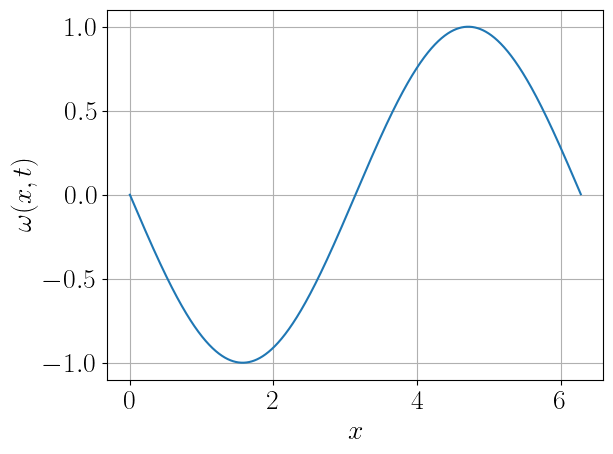

1


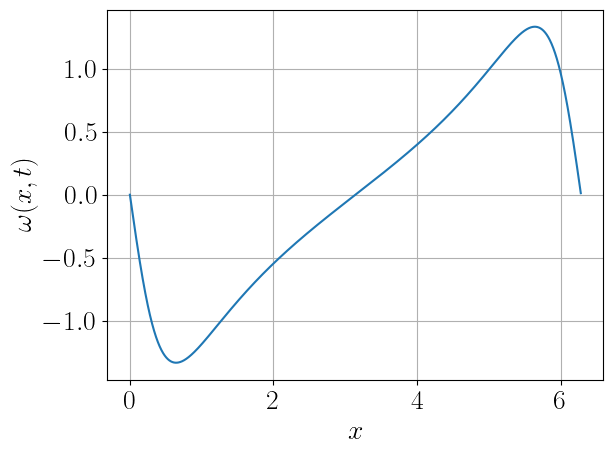

1.5


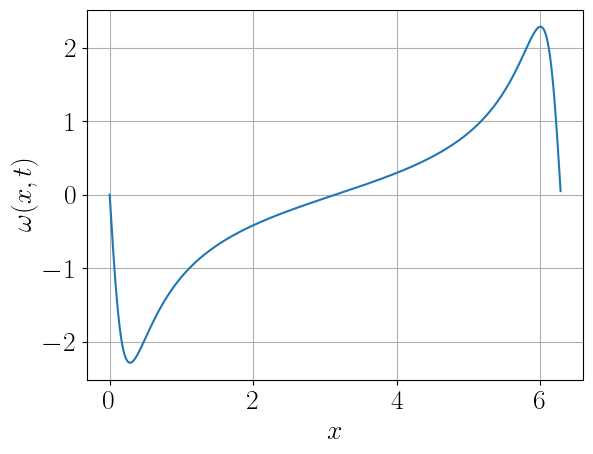

1.75


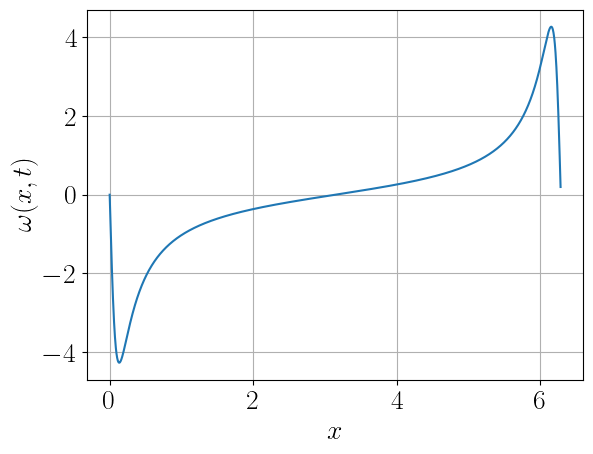

1.9


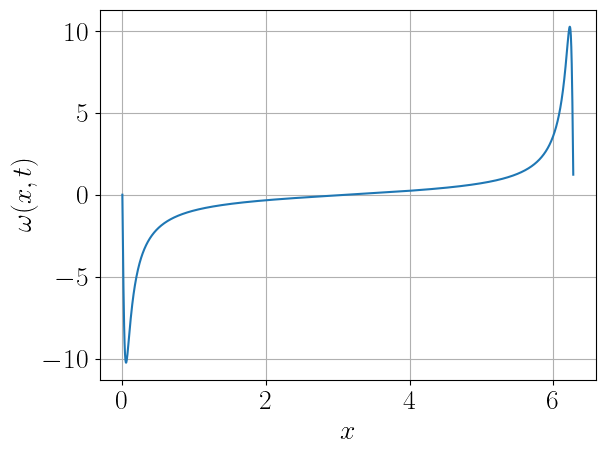

1.95


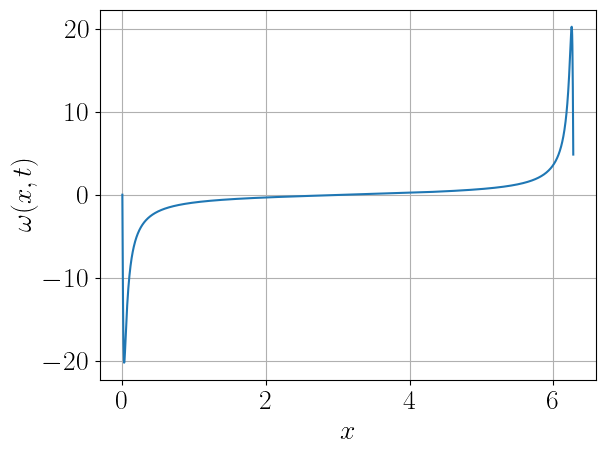

In [5]:
print(snapshot_times)
print(len(snapshots))
for i in range(len(snapshots)):    
    plt.figure()
    print(snapshot_times[i])
    plt.plot(x, snapshots[i])
    t = snapshot_times[i]
    exact = 4 * omega0(x) / ((2 - t * hilbert(omega0(x))) ** 2 + t**2 * omega0(x) ** 2)
    # plt.plot(x, exact, linestyle='--')
    plt.xlabel(r"$x$")
    plt.ylabel(r"$\omega(x,t)$")
    # plt.title(f"Snapshot at t={snapshot_times[i]:.2f}")
    plt.grid(True)
    plt.savefig(f"plots/clm/snapshot_t{t:.2f}.pdf", dpi=300, bbox_inches='tight')
    plt.show()

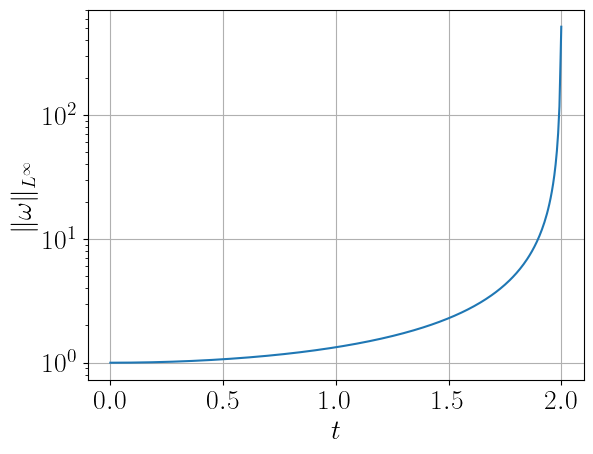

In [6]:
plt.figure()
plt.plot(times, maxomega)
plt.xlabel(r"$t$")
plt.ylabel(r"$\|\omega\|_{L^\infty}$")
plt.yscale("log")
# plt.title("Crescita di max |omega| per il modello CLM")
plt.grid(True)
plt.savefig("plots/clm/max_omega_vs_t.pdf", dpi=300, bbox_inches='tight')

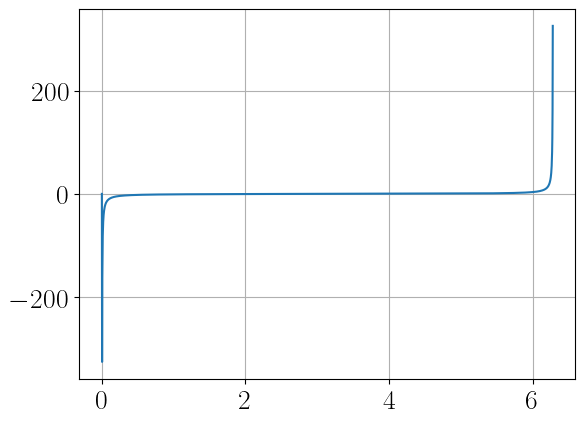

In [7]:
def omegaEx(x,t):
    return -np.sin(x) / (1+(t/2)**2 - t*np.cos(x))


plt.plot(x,omegaEx(x,1.9999))
plt.grid(True)

IndexError: index 39998 is out of bounds for axis 0 with size 39998

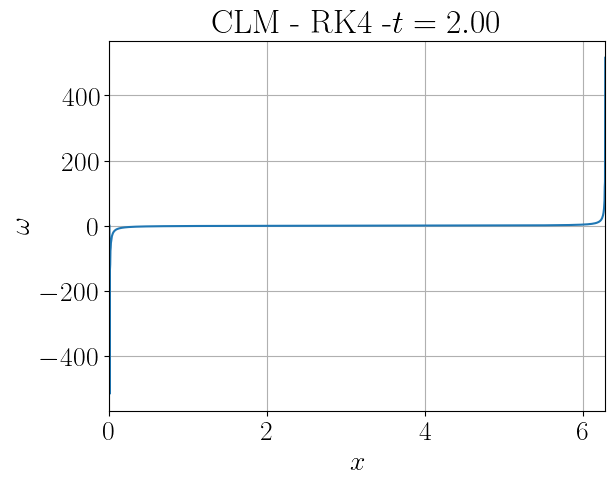

In [10]:
anim = viz_tools.anim_1D(x, omegas.T, np.arange(nsteps) * dt, True, (0, 2 * np.pi), (-1.2, 1.2), 'CLM - RK4 -', f'plots/clm/clm_vid', 'mp4')
anim = viz_tools.anim_1D(x, omegas.T, np.arange(nsteps) * dt, True, (0, 2 * np.pi), (-1.2, 1.2), 'CLM - RK4 - ', f'plots/clm/clm_vid', 'gif')